# DATA 101 — Intro to Modeling (Session 2)

**Focus:** Multiple regression, interpretation, multicollinearity (VIF), interaction terms, adjusted $R^2$, Q–Q plot (normality), and simple model comparison.

> This notebook is self-contained. If `Advertising.csv` is not present, it will generate a realistic synthetic dataset.


## 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("statsmodels:", sm.__version__)

numpy: 2.3.1
pandas: 2.3.1
matplotlib: 3.10.3
statsmodels: 0.14.5


## 1. Load data (or create synthetic Advertising-like data)

In [2]:
csv_path = "./data/Advertising.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    # Generate a dataset similar to ISLR's Advertising
    rng = np.random.default_rng(2025)
    n = 200
    TV = rng.uniform(0, 300, n)          # $k
    Radio = rng.uniform(0, 50, n)        # $k
    Newspaper = rng.uniform(0, 100, n)   # $k
    # True relationship with noise
    Sales = 3.0 + 0.045*TV + 0.18*Radio + 0.01*Newspaper + rng.normal(0, 1.2, n)
    df = pd.DataFrame({"TV": TV, "Radio": Radio, "Newspaper": Newspaper, "Sales": Sales})
    df.to_csv(csv_path, index=False)

df.head()

,TV,Radio,Newspaper,Sales
0,283.059752,22.400382,13.046499,20.792160
1,107.826310,17.833197,17.377088,10.954803
2,235.441624,8.592322,25.762048,16.113905
3,177.383456,34.092156,92.782412,16.974606
4,88.298568,44.342255,80.859978,15.688330


## 2. Multiple Regression: `Sales ~ TV + Radio + Newspaper`

In [3]:
X = sm.add_constant(df[["TV","Radio","Newspaper"]])
y = df["Sales"]

model_full = sm.OLS(y, X).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     855.1
Date:                Wed, 22 Oct 2025   Prob (F-statistic):          2.79e-112
Time:                        14:06:05   Log-Likelihood:                -333.76
No. Observations:                 200   AIC:                             675.5
Df Residuals:                     196   BIC:                             688.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8913      0.302      9.570      0.0

### 2.1 Coefficient table (estimates, standard errors, p-values)

In [4]:
coef_table = pd.DataFrame({
    "coef": model_full.params,
    "std_err": model_full.bse,
    "t": model_full.tvalues,
    "p_value": model_full.pvalues
})
coef_table

,coef,std_err,t,p_value
const,2.891262,0.302130,9.569606,4.811735e-18
TV,0.045349,0.001065,42.599835,4.890812e-101
Radio,0.186626,0.006299,29.628924,2.548206e-74
Newspaper,0.006561,0.003063,2.142152,3.341505e-02


### Interpretation:

* **Intercept (2.89):**
  When all advertising spending is zero (TV, Radio, and Newspaper = 0), predicted sales are **about 2.9 units**.

* **TV (0.045):**
  For each additional **$1,000 spent on TV advertising**, sales increase by **about 0.045 units**, assuming Radio and Newspaper spending stay the same.

* **Radio (0.187):**
  For each additional **$1,000 spent on Radio advertising**, sales increase by **about 0.19 units**, holding TV and Newspaper constant.

* **Newspaper (0.0066):**
  For each additional **$1,000 spent on Newspaper ads**, sales increase by **about 0.007 units**, controlling for TV and Radio.
  This effect is small but statistically significant (p ≈ 0.03).

**Summary interpretation:**
TV and Radio both have strong, significant effects on sales; Newspaper has a weaker but still statistically detectable effect.


## 3. Model Fit and Comparison (Adjusted $R^2$)

In [5]:

# Reduced model: drop Newspaper to see comparison
X_red = sm.add_constant(df[["TV","Radio"]])
model_reduced = sm.OLS(y, X_red).fit()

print("Full model Adj R^2:", round(model_full.rsquared_adj, 4))
print("Reduced model Adj R^2:", round(model_reduced.rsquared_adj, 4))


Full model Adj R^2: 0.9279
Reduced model Adj R^2: 0.9266


### Interpretation:

* The **full model** (with TV, Radio, and Newspaper) explains about **92.8%** of the variation in Sales after adjusting for the number of predictors.
* The **reduced model** (with only TV and Radio) explains about **92.7%** of the variation.

The difference (0.9279 − 0.9266 = 0.0013) is **very small**, meaning that adding **Newspaper** barely improves the model’s explanatory power.

**Conclusion:**
The simpler model with only **TV and Radio** performs almost as well as the full model, so it’s preferable for clarity and efficiency.

## 4. Multicollinearity: Variance Inflation Factor (VIF)

In [6]:
# Compute VIFs for the predictors in the full model (exclude the constant)
X_vif = df[["TV","Radio","Newspaper"]].copy()
X_vif_const = sm.add_constant(X_vif)

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame({
    "feature": ["const"] + list(X_vif.columns),
    "VIF": [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
})
vif_df

,feature,VIF
0,const,10.854825
1,TV,1.012438
2,Radio,1.007246
3,Newspaper,1.013304


### Interpretation:

* **TV (1.01), Radio (1.01), Newspaper (1.01):**
  All VIF values are very close to **1**, meaning the predictors are **not correlated** with each other.
  There is **no evidence of multicollinearity** in this model.

* **Constant (10.85):**
  The intercept’s VIF is often high and **not meaningful**, since it depends on variable scaling and centering.
  It can be safely ignored when assessing multicollinearity.

**Conclusion:**
All predictors are independent enough for reliable coefficient interpretation.

## 5. Interaction Terms

We add an interaction between `TV` and `Radio` to allow the effect of `TV` to depend on the level of `Radio` (and vice versa):

$\;\;\;\; Sales = \beta_0 + \beta_1\,TV + \beta_2\,Radio + \beta_3\,(TV \times Radio) + \varepsilon$


In [7]:
df["TVxRadio"] = df["TV"] * df["Radio"]
X_int = sm.add_constant(df[["TV","Radio","TVxRadio"]])
model_int = sm.OLS(y, X_int).fit()
print(model_int.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     847.0
Date:                Wed, 22 Oct 2025   Prob (F-statistic):          6.65e-112
Time:                        14:06:05   Log-Likelihood:                -334.65
No. Observations:                 200   AIC:                             677.3
Df Residuals:                     196   BIC:                             690.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8233      0.364      7.756      0.0

### 5.1 Interpreting the interaction

In [8]:
b0, b_tv, b_radio, b_int = model_int.params
print("Estimated coefficients:")
print(f"Intercept: {b0:.3f}, TV: {b_tv:.4f}, Radio: {b_radio:.4f}, TVxRadio: {b_int:.6f}")

# Example: marginal effect of TV at two Radio levels
for r in [0, df['Radio'].median()]:
    slope_tv_at_r = b_tv + b_int * r
    print(f"Marginal effect of TV when Radio={r:.2f}: {slope_tv_at_r:.4f} (change in Sales per 1k TV)")

Estimated coefficients:
Intercept: 2.823, TV: 0.0480, Radio: 0.2042, TVxRadio: -0.000119
Marginal effect of TV when Radio=0.00: 0.0480 (change in Sales per 1k TV)
Marginal effect of TV when Radio=22.71: 0.0453 (change in Sales per 1k TV)


### Interpretation:

* **Intercept (2.82):**
  Predicted sales are about **2.8 units** when both TV and Radio spending are zero.

* **TV (0.048):**
  When Radio spending is zero, each additional **$1,000 in TV advertising** increases sales by **0.048 units**.

* **Radio (0.204):**
  When TV spending is zero, each additional **$1,000 in Radio advertising** increases sales by **0.204 units**.

* **Interaction (–0.000119):**
  The negative sign means that the effect of TV **slightly decreases** as Radio spending increases —
  in other words, combining the two channels yields a **smaller incremental gain** than the sum of their separate effects.

**Example:**

* At **Radio = 0**, TV’s effect ≈ 0.048 per $1k.
* At **Radio = 22.7**, TV’s effect ≈ 0.045 per $1k.

**Conclusion:**
TV and Radio are both strong predictors of sales, but their joint effect shows **diminishing returns** — running both ads together adds less incremental value than running each independently.

### Interpretation with that p-value included:

* The **interaction coefficient (–0.000119)** has a **p-value of 0.095**, which is **slightly above** the common 0.05 cutoff.
  This means the interaction between TV and Radio is **not statistically significant at the 5% level**, though it shows a **weak trend** toward diminishing joint effects.

**In simple terms:**

* The data hint that combining TV and Radio ads may slightly reduce each other’s marginal impact,
  but this pattern is **not strong enough** to conclude that a real interaction exists.

**Conclusion:**
You can mention the negative interaction as an *interesting possibility*, but from a statistical standpoint,
the safer interpretation is that **TV and Radio effects are mostly additive** — each channel contributes to sales independently.

## 6. Normality Check: Q–Q Plot of Residuals

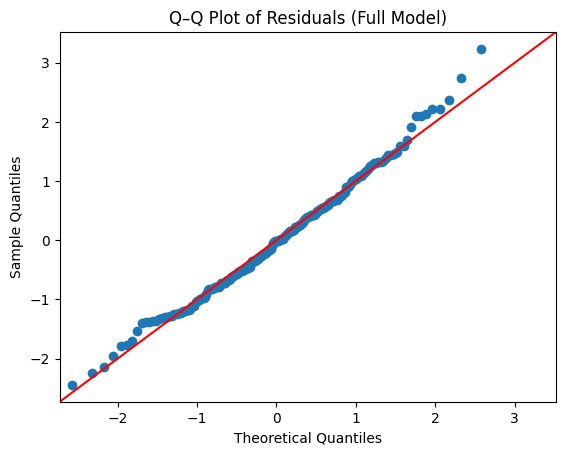

In [9]:
residuals = model_full.resid
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of Residuals (Full Model)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

### 6.1 Optional: Histogram of Residuals

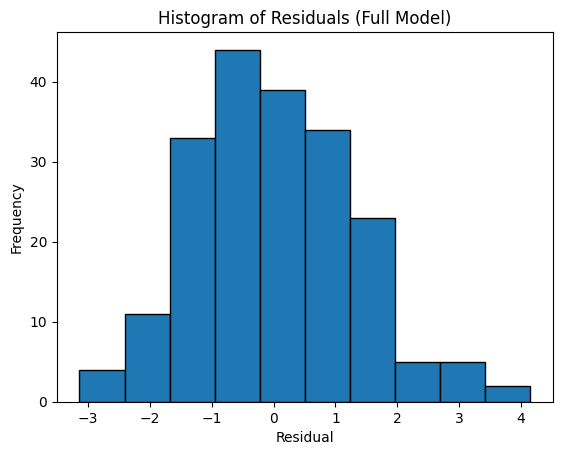

In [10]:
plt.hist(residuals, bins=10, edgecolor='black')
plt.title("Histogram of Residuals (Full Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()